# Validation Test 0.4.0: Flat-k P(k) With Gaussian Noise

Taylor Dibblee-Barkman and the HERA Validation Team

<h3 id="tocheading">Table of Contents</h3>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Setup and Metadata

### Abstract

This notebook validates the hera_pspec pipeline's ability to recover the mean power from a flat-k Gaussian delay spectrum from an ensemble of simulations with random Gaussian noise added to the visibilities. We extract the mean power estimate from each simulation using the hera_pspec pipeline and perform an ensemble average on the resulting power and compare to the mean from a flat-k Gaussian delay spectrum without added noise. The percent difference averaged over 500 simulations is found to be less than 0.04%. 

### Imports

In [2]:
%matplotlib inline
from pyuvdata import UVData
import hera_pspec as hp
import numpy as np
import matplotlib.pyplot as plt
import copy, os, itertools, inspect
from hera_pspec.data import DATA_PATH
from datetime import datetime

In [3]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

### Description

In [4]:
print("Last executed: %s"%str(datetime.now()))

Last executed: 2020-05-24 12:12:47.683224



- **Major Step Description:** Add random Gaussian noise to simulated data and estimate power spectrum with hera_pspec. 
- **Minor Variation Description:** Compare mean power with and without added noise by performing an ensemble average. 
- **Pipelines Tested:** hera_pspec 
- **Criteria**:
  1. Ensemble averaged mean power estimate with added noise agrees with mean power estimate without noise. 

### Summary

The results of this validation test, in reference to the outlined criteria, are
1. Test passes, ensemble averaged mean power estimate with added noise agrees with power estimate without added noise within 0.05% for 500 noise realizations. 

The fractional difference between power estimates with and without added noise were averaged over an increasing number of noise realizations in increments of 5 and was found to converge to 0.0004 or less. Reducing the standard deviation of the random Gaussian noise lowers the fractional difference between power estimates.

### Software

HERA software used in this validation test, with associate git commit hash:

* {``pyuvdata``: `21c07ab0ad4eb2b50283fa776487ad4afabf3456`}
* {``hera_pspec``: `79c4d17bd5d73097c56313e0338cf107191a2723`}

Versions of other software used in this validation test:

* {``numpy``: v1.17.2}
* {``matplotlib``: v3.1.1}

### Data

The following paths reflect the exact locations of all data used in this test. The mean powers with noise added to the data are generated using the python script "noise_loops.py" that is included with this notebook.

In [5]:
sim_path = "/lustre/aoc/projects/hera/alanman/eor_sky_sim/"

## Flat Power Spectrum Estimate

This section is used to recover the mean power over all time samples and all delays without added noise.

In [6]:
# For the simulated data, baselines are (0,11), (0,12), (11,12)
# Use the full spectral window: spw_ranges=[(0, 384)]

# Power without noise for all 491 time samples, all 100 delays, and all 3 baselines
Powers_ = []

# select the data file to load
dfile = os.path.join(sim_path, 'eorsky_3.00hours_Nside128_sigma0.03_fwhm12.13_uv.uvh5')
# Load into UVData objects
uvd = UVData()
uvd.read_uvh5(dfile)
        
# (From the PSpecBeam Tutorial)
# Each beam is defined over a frequency interval:
beam_freqs = uvd.freq_array[0]

# Create a new Gaussian beam object with full-width at half-max. of 12.13 degrees, converted to radians
beam_gauss = hp.PSpecBeamGauss(fwhm=12.13*np.pi/180, beam_freqs=beam_freqs)
        
# Apply unit conversion factor to UVData
# The expression [None, None, :, None] reshapes the conversion factor into the same shape as as the data_array
uvd.data_array *= beam_gauss.Jy_to_mK(np.unique(uvd.freq_array))[None, None, :, None]
      
# Instantiate a Cosmo Conversions object
# we will need this cosmology to put the power spectra into cosmological units
cosmo = beam_gauss.cosmo
print(cosmo)
        
# Gaussian beam object
uvb = beam_gauss
        
# slide the time axis of uvd by one integration
uvd1 = uvd.select(times=np.unique(uvd.time_array)[:-1:2], inplace=False)
uvd2 = uvd.select(times=np.unique(uvd.time_array)[1::2], inplace=False)
      
# Create a new PSpecData object, and don't forget to feed the beam object
ds = hp.PSpecData(dsets=[uvd1, uvd2], wgts=[None, None], beam=uvb)
       
# Because the LST integrations are offset by more than ~15 seconds we will get a warning
# but this is okay b/c it is still **significantly** less than the beam-crossing time and we are using short
# baselines...
# here we phase all datasets in dsets to the zeroth dataset
ds.rephase_to_dset(0)

# change units of UVData objects
ds.dsets[0].vis_units = 'mK'
ds.dsets[1].vis_units = 'mK'

# Specify which baselines to include
baselines = [(0, 11), (0, 12), (11, 12)]

# we will use the baselines list to produce 491 power spectra 
# whose data will be drawn from the dsets[0] and dsets[1]
# across two spectral windows with identity weighting 
# and a blackman-harris taper.
        
# Take the full spw range: (0, 384)
uvp = ds.pspec(baselines, baselines, (0, 1), [('pI', 'pI')], spw_ranges=[(0, 384)], input_data_weight='identity',
               norm='I', taper='blackman-harris', verbose=True)
        
# Set the spectral window
spw = 0
# keys for 3 baselines
key_bl = []
for j in range(len(baselines)):
    key_bl.append((spw, (baselines[j], baselines[j]), 'pI'))
# Append mean powers for the baselines
power_bl = []
for j in range(len(baselines)):
    power_bl.append((np.real(uvp.get_data(key_bl[j]))))
# delays
dlys = uvp.get_dlys(spw) * 1e9
# Powers at each delay for all time samples
Powers_.append(power_bl)
# Mean power over all time samples and all delays
Powers_dm = np.mean(np.mean(Powers_, axis=2), axis=2)

Telescope eorsky is not in known_telescopes.


Cosmo_Conversions object at <0x7f63dac0f410>
Om_L : 0.6844; Om_b : 0.0491; Om_c : 0.2644; Om_M : 0.3135; Om_k : 0.0021; H0 : 67.2700

Setting spectral range: (0, 384)

Using polarization pair: ('pI', 'pI')

(bl1, bl2) pair: ((0, 11), (0, 11))
pol: (1, 1)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 12), (0, 12))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((11, 12), (11, 12))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...


## Flat Power Spectrum Estimate with Noise

The python script included with this notebook is used to generate 500 noise realizations and estimate the mean power with added noise over all time samples and all delays. Four choices of standard deviations were used for each noise realization: 0.05 mK, 0.125 mK, 0.25 mK, and 0.5 mK.

## Data Visualization

In this section, the results are plotted using data from the previous sections. We compare the mean power with and without added noise for 500 noise realizations and four choices of standard deviation for each of three baselines. We compare the ensemble-averaged fractional difference between mean powers over an increasing number of noise realizations in increments of 5 for each baseline as well as a baseline average. 

### Ensemble-Averaged Power

In [7]:
# load the data
# This file contains the mean powers generated using
# "noise_loops.py" for 500 Gaussian noise realizations
P = np.load("Parr_500loops.npz")

# Noise realization number
x_arr = np.arange(1, len(P['power_1'].T[0])+1, step=1)
# Mean powers without noise added
no_noise = Powers_dm.T
# Specify index (baseline) for the noiseless mean when plotting in axs.plot
y_arr = np.repeat(no_noise, len(P['power_1'].T[0]), axis=1)

In [8]:
# Order the mean powers by decreasing sigma
m_sig = np.array([P['power_1'].T, P['power_05'].T, P['power_025'].T, P['power_01'].T])

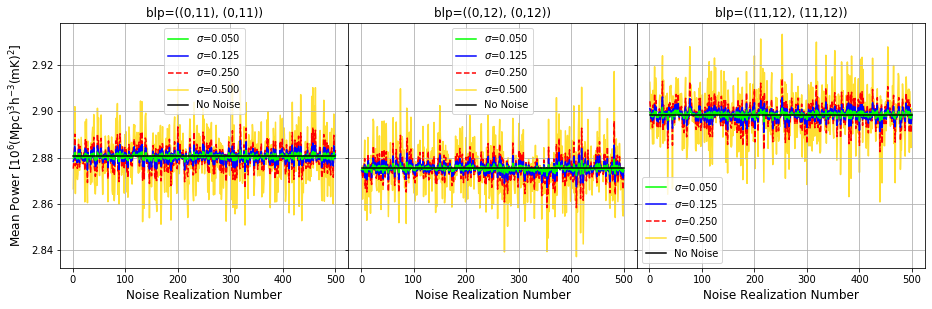

In [9]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15.5, 4.5))
fig.subplots_adjust(wspace=0.0)
axs = axs.ravel()

blp_label = np.array(['blp=((0,11), (0,11))', 'blp=((0,12), (0,12))', 'blp=((11,12), (11,12))']) 

for i in range(3):
    axs[i].plot(x_arr, m_sig[3][i]*(10**-6), color='lime', label='$\sigma$=0.050', zorder=4)
    axs[i].plot(x_arr, m_sig[2][i]*(10**-6), color='blue', label='$\sigma$=0.125', zorder=3)
    axs[i].plot(x_arr, m_sig[1][i]*(10**-6), color='red', linestyle='--', label='$\sigma$=0.250', zorder=2)
    axs[i].plot(x_arr, m_sig[0][i]*(10**-6), color='gold', alpha=0.8, label='$\sigma$=0.500', zorder=1)
    axs[i].plot(x_arr, y_arr[i]*(10**-6), color='black', label='No Noise', zorder=5)
    
    axs[i].set_title(blp_label[i], fontsize=12)
    axs[i].set_xlabel('Noise Realization Number', fontsize=12)
    axs[0].set_ylabel('Mean Power [10$^6$(Mpc)$^3$h$^{-3}$(mK)$^2$]', fontsize=12)

    axs[i].grid()
    axs[i].legend()
    
plt.show();

**Figure 1** | Time and delay averaged mean power with added noise is plotted against noise realization number for three baselines and is compared to the time and delay averaged power without added noise. Four choices of standard deviation $\sigma$ (mK) are used to study whether the signal can be recovered. Visually, the mean powers with added noise appear to converge around the true mean, with larger fluctuations for larger $\sigma$.

### Ensemble-Averaged Fractional Difference

In [10]:
# Function to rebin the residuals in increments of five from 0 to 500
def rebin(sig_ind, base_ind):
    """
    Parameters
    
    sig_ind: index of choice of standard deviation
    base_ind: index of baseline pair
    
    Returns the fractional difference between powers with and
    without added noise, averaged over increasing increments of 5.
    
    """
    
    # Initialize residuals
    res_m = []
    # Average over number of noise realizations in increments of 5
    for i in range(1, int(len(P['power_1'].T[0])/5) + 1):
        res_m.append((np.mean((m_sig[sig_ind][base_ind].T)[0:5*i]) - 
                      np.mean(y_arr[base_ind][0:5*i]))/ np.mean(y_arr[base_ind][0:5*i]))
    # Return residuals
    return res_m

In [11]:
# Rebin the number of noise realizations
rb_x = np.arange(5, len(P['power_1'].T[0]) + 1, step=5)

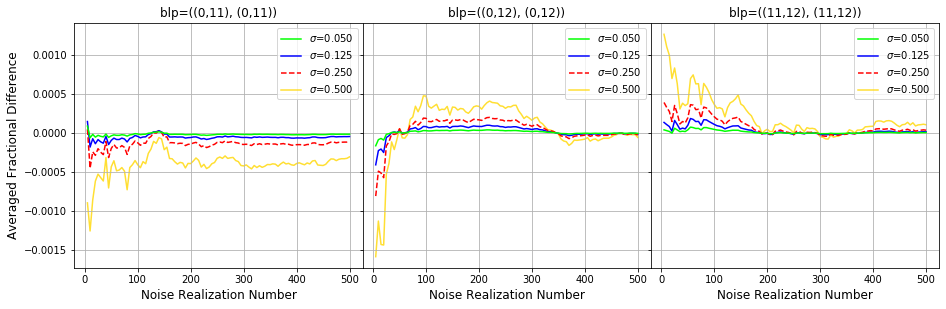

In [12]:
# Plot the ensemble-averaged fractional difference for three baselines

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15.5, 4.5))
fig.subplots_adjust(wspace=0.0)
axs = axs.ravel()

blp_label = np.array(['blp=((0,11), (0,11))', 'blp=((0,12), (0,12))', 'blp=((11,12), (11,12))']) 

for i in range(3):
    axs[i].plot(rb_x, rebin(3,i), color='lime', label='$\sigma$=0.050', zorder=4)
    axs[i].plot(rb_x, rebin(2,i), color='blue', label='$\sigma$=0.125', zorder=2)
    axs[i].plot(rb_x, rebin(1,i), color='red', linestyle='--', label='$\sigma$=0.250', zorder=3)
    axs[i].plot(rb_x, rebin(0,i), color='gold', alpha=0.8, label='$\sigma$=0.500', zorder=1)

    axs[i].set_title(blp_label[i], fontsize=12)
    axs[i].set_xlabel('Noise Realization Number', fontsize=12)
    axs[0].set_ylabel('Averaged Fractional Difference', fontsize=12)
    
    axs[i].grid()
    axs[i].legend()

plt.show();

**Figure 2** | The ensemble-averaged fractional difference between mean powers with and without added noise is plotted against the number of noise realizations that the fractional difference is averaged over for each baseline. Visually, the fractional difference converges to zero as the number of noise realizations increases. The ensemble-averaged fractional difference is lower for the smaller choices of standard deviation $\sigma$ (mK). The baseline pair ((0,11), (0,11)) has the largest ensemble-averaged fractional difference over all noise realizations, with a percent difference of less than 0.04%.

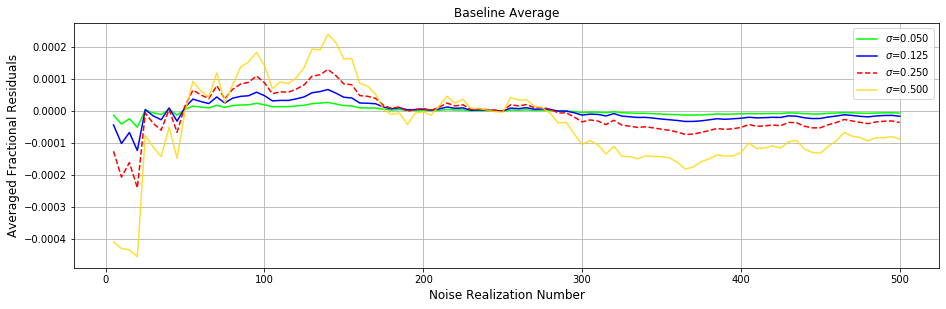

In [13]:
# Plot the ensemble-averaged fraction difference, averaged over the baselines

fig, ax = plt.subplots(1,1, figsize=(15.5, 4.5))

ax.plot(rb_x, np.mean((rebin(3,0), rebin(3,1), rebin(3,2)), axis=0), color='lime', label='$\sigma$=0.050')
ax.plot(rb_x, np.mean((rebin(2,0), rebin(2,1), rebin(2,2)), axis=0), color='blue', label='$\sigma$=0.125')
ax.plot(rb_x, np.mean((rebin(1,0), rebin(1,1), rebin(1,2)), axis=0), color='red', linestyle='--', label='$\sigma$=0.250')
ax.plot(rb_x, np.mean((rebin(0,0), rebin(0,1), rebin(0,2)), axis=0), color='gold', alpha=0.8, label='$\sigma$=0.500')

ax.set_title('Baseline Average', fontsize=12)
ax.set_xlabel('Noise Realization Number', fontsize=12)
ax.set_ylabel('Averaged Fractional Residuals', fontsize=12)

ax.grid()
ax.legend()
plt.show();

**Figure 3** | The ensemble-averaged fractional difference between powers with and without added noise is plotted against the number of noise realizations that the fractional difference is averaged over for the average over the three baselines above. Visually, the fractional difference converges to zero as the number of noise realizations increases. The ensemble-averaged fractional difference is lower for the lower choices of standard deviation $\sigma$ (mK). The ensemble-averaged fractional difference is largest for the choice of standard deviation $\sigma$=1.0 mK.